# Metalens Surrogate

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import tidy3d as td
import tidy3d.web as web
import tidy3d.plugins.design as tdd


In [2]:
lda0 = 10.6  # operation wavelength
freq0 = td.C_0 / lda0  # operation frequency
ldas = np.linspace(10.1, 11.1, 101)  # operation wavelength
freqs = td.C_0 / ldas

P = 6.2  # period of the unit cell
h = 6.8  # height of the pillar

inf_eff = 1e5  # effective infinity

In [3]:
n_si = 3.43  # refractive index of silicon
si = td.Medium(permittivity=n_si**2)

In [4]:
def create_ellipsis(major_radius, minor_radius, angle, x_offset, y_offset):
    def generate_ellipse_points(major_radius, minor_radius, x_offset, y_offset, num_points=100):
            """
            Generate points along the boundary of an ellipse.

            Parameters:
            - major_radius (float): The length of the semi-major axis (major radius).
            - minor_radius (float): The length of the semi-minor axis (minor radius).
            - num_points (int): The number of points to generate (default is 100).

            Returns:
            - numpy.ndarray: An array of shape (num_points, 2) containing the (x, y) coordinates of the ellipse.
            """
            t = np.linspace(0, 2 * np.pi, num_points + 1)[:-1] # TH: avoid duplicate points at 0=2pi
            
            # Parametric equations for the ellipse
            x = major_radius * np.cos(t)
            y = minor_radius * np.sin(t)
            
            # Combine x and y into a single array
            points = np.column_stack((x, y))
            
            return points

    angle_rad = np.deg2rad(angle) # define angle in radians for `cos` and `sin` (if input is degrees?)
    vertices = generate_ellipse_points(major_radius, minor_radius, x_offset, y_offset)
    rot_mat = [[np.cos(angle_rad), -np.sin(angle_rad)], [np.sin(angle_rad), np.cos(angle_rad)]]
    vertices_rotated = vertices.dot(rot_mat)

    # Add offset
    vertices_rotated[:, 0] = vertices_rotated[:, 0] + x_offset
    vertices_rotated[:, 1] = vertices_rotated[:, 1] + y_offset
    
    ellipsis = td.Structure(
        geometry=td.PolySlab(vertices=vertices_rotated, axis=2, slab_bounds=(0, h)), medium=si,
    )

    return ellipsis


def make_sim(major_radius, minor_radius, angle):

    # define geometry
    substrate_geo = td.Box.from_bounds(rmin=(-inf_eff, -inf_eff, -inf_eff), rmax=(inf_eff, inf_eff, 0))
    substrate = td.Structure(geometry=substrate_geo, medium=si, name="substrate")
    
    # Define ellipses
    ellipsis = create_ellipsis(major_radius, minor_radius, angle, 0, 0)

    # add a plane wave source
    plane_wave1 = td.PlaneWave(
        source_time=td.GaussianPulse(freq0=freq0, fwidth=freq0 / 10),
        size=(td.inf, td.inf, 0),
        center=(0, 0, -0.1 * lda0),
        direction="+",
    )

    # add a plane wave source
    # plane_wave2 = td.PlaneWave(
    #     source_time=td.GaussianPulse(freq0=freq0, fwidth=freq0 / 10, phase=np.pi/2),
    #     size=(td.inf, td.inf, 0),
    #     center=(0, 0, -0.1 * lda0),
    #     direction="+",
    #     pol_angle=np.pi/2
    # )

    # define a diffraction monitor to calculate the transmission coefficient
    monitor_t = td.DiffractionMonitor(
        center=[0, 0, h + 0.5 * lda0], size=[td.inf, td.inf, 0], freqs=freqs, name="t"
    )

    run_time = 5e-12  # simulation run time

    # define boundary conditions
    boundary_spec = td.BoundarySpec(
        x=td.Boundary.periodic(),
        y=td.Boundary.periodic(),
        z=td.Boundary(minus=td.PML(), plus=td.PML()),
    )

    Lz = h + 1.2 * lda0  # simulation domain size in z direction
    min_steps_per_wvl = 12  # minimum steps per wavelength for the grid

    # define a function to create unit cell simulation given pillar diameter
    sim = td.Simulation(
        center=(0, 0, h / 2),
        size=(P, P, Lz),
        grid_spec=td.GridSpec.auto(min_steps_per_wvl=min_steps_per_wvl, wavelength=lda0),
        structures=[ellipsis, substrate],
        sources=[plane_wave1],
        monitors=[monitor_t],
        run_time=run_time,
        boundary_spec=boundary_spec,  # pml is applied to z direction. x and y directions are periodic
    )

    return sim

In [5]:
sim = make_sim(1.5, 0.5, 0)
sim.plot_3d()

In [6]:
def fn_post(sim_data):
    t = sim_data["t"]
    return {"t": t}

In [7]:
method = tdd.MethodMonteCarlo(
    num_points=100,
    seed=1,
)

maj_r = tdd.ParameterFloat(name="major_radius", span=(0.75, 1.8))
min_r = tdd.ParameterFloat(name="minor_radius", span=(0.75, 1.8))
ang = tdd.ParameterFloat(name="angle", span=(0, 180))
parameters = [maj_r, min_r, ang]

output_dir = "/home/matt/Documents/Flexcompute/metalens_linear_source/data"
design_space = tdd.DesignSpace(
    method=method,
    parameters=parameters,
    task_name="metalens_1",
    folder_name="metalensV2",
    path_dir=output_dir,
)


In [57]:
results = design_space.run(make_sim, fn_post, verbose=True)
df = results.to_dataframe()

17:39:26 BST Running 100 Simulations

In [8]:
# TESTING: Save off the df or load the df
import pickle
import os
os.chdir("/home/matt/Documents/Flexcompute/metalens_linear_source/data")
# with open("result_100.pkl", "wb") as out_file:
#     pickle.dump(results, out_file)


with open("result_100.pkl", "rb") as in_file:
    results = pickle.load(in_file)

df = results.to_dataframe()

## Surrogate

In [20]:
expanded_df = df.copy()
expanded_df["transmission"] = expanded_df["t"].apply(lambda x: x.amps.sel(polarization="p").squeeze())
expanded_df.drop(["t"], axis=1, inplace=True)
expanded_df = expanded_df.explode(["transmission"]).reset_index(drop=True)
expanded_df["freq"] = expanded_df["transmission"].apply(lambda x: float(x.f))

# Complex numbers 
expanded_df["complex"] = expanded_df["transmission"].apply(lambda x: x.data)
expanded_df["real"] = expanded_df["complex"].apply(lambda x: x.real)
expanded_df["imag"] = expanded_df["complex"].apply(lambda x: x.imag)

# Processing
# expanded_df["transmittance"] = expanded_df["transmission"].apply(lambda x: float(np.abs(x)))
# expanded_df["theta"] = expanded_df["transmission"].apply(lambda x: np.unwrap(np.angle(x.expand_dims("f"))).reshape(-1))
# expanded_df["theta"] = expanded_df["theta"].apply(lambda x: float(x[0] / (2 * np.pi)))
# expanded_df["norm_theta"] = expanded_df["theta"].apply(lambda x: (x - expanded_df.theta.min()) / (expanded_df.theta.max() - expanded_df.theta.min()))

print()

In [21]:
import torch
import torch.nn as nn
import torch.optim as optim

from tidy3d.plugins.design.surrogate_object import AI_Model

# Constants
output_dir = "/home/matt/Documents/Flexcompute/metalens"
data_dir = ["/home/matt/Documents/Flexcompute/metalens/data/"]

test_percentage = 0.20
valid_percentage = 0.20
batch_size = 512
epochs = 100

trial_count = 20

model = AI_Model(output_dir, data_dir, seed=1)

model.load_data_from_df(
    df=expanded_df,
    label_names=["real", "imag"],
    feature_names=["major_radius", "minor_radius", "angle", "freq"],
    test_percentage=test_percentage,
    valid_percentage=valid_percentage,
    batch_size=batch_size,
    individual_feature_scaling=True
)

loss_fn = nn.MSELoss()

Using existing directory at pickle_data
Using existing directory at models
Using device cuda:0


In [22]:
# Define the model in PyTorch
class VariableANN(nn.Module):
    def __init__(self, input_size, neurons, dropout) -> None:
        super().__init__()
        self.layers = nn.ModuleList()
        self.layers.append(nn.Linear(input_size, neurons[0]))

        for i in range(1, len(neurons)):
            self.layers.append(nn.Linear(neurons[i - 1], neurons[i]))

        self.layers.append(nn.Linear(neurons[-1], 2))

        self.drop = nn.Dropout(dropout)
        self.relu = nn.ReLU()

    def forward(self, x):
        for layer in self.layers[:-1]:
            x = self.drop(self.relu(layer(x)))

        x = self.layers[-1](x)

        return x

Using existing directory at Model1


  3%|▎         | 3/100 [00:00<00:04, 23.07it/s]

Best State Updated. Epoch: 0
Best State Updated. Epoch: 1
Best State Updated. Epoch: 2
Best State Updated. Epoch: 3


  6%|▌         | 6/100 [00:00<00:03, 25.54it/s]

Best State Updated. Epoch: 4
Best State Updated. Epoch: 5


  9%|▉         | 9/100 [00:00<00:03, 26.43it/s]

Best State Updated. Epoch: 6
Best State Updated. Epoch: 7
Best State Updated. Epoch: 8
Best State Updated. Epoch: 9


 12%|█▏        | 12/100 [00:00<00:03, 25.72it/s]

Best State Updated. Epoch: 10
Best State Updated. Epoch: 11


 15%|█▌        | 15/100 [00:00<00:03, 26.39it/s]

Best State Updated. Epoch: 12
Best State Updated. Epoch: 13
Best State Updated. Epoch: 14
Best State Updated. Epoch: 15


 18%|█▊        | 18/100 [00:00<00:03, 26.00it/s]

Best State Updated. Epoch: 16
Best State Updated. Epoch: 17


 24%|██▍       | 24/100 [00:01<00:03, 20.56it/s]

Best State Updated. Epoch: 18
Best State Updated. Epoch: 19
Best State Updated. Epoch: 20
Best State Updated. Epoch: 21
Best State Updated. Epoch: 22
Best State Updated. Epoch: 23


 30%|███       | 30/100 [00:01<00:03, 23.21it/s]

Best State Updated. Epoch: 24
Best State Updated. Epoch: 25
Best State Updated. Epoch: 26
Best State Updated. Epoch: 27
Best State Updated. Epoch: 28
Best State Updated. Epoch: 29


 36%|███▌      | 36/100 [00:01<00:02, 25.32it/s]

Best State Updated. Epoch: 30
Best State Updated. Epoch: 31
Best State Updated. Epoch: 32
Best State Updated. Epoch: 33
Best State Updated. Epoch: 34
Best State Updated. Epoch: 35


 42%|████▏     | 42/100 [00:01<00:02, 25.58it/s]

Best State Updated. Epoch: 36
Best State Updated. Epoch: 37
Best State Updated. Epoch: 38
Best State Updated. Epoch: 39
Best State Updated. Epoch: 40
Best State Updated. Epoch: 41


 48%|████▊     | 48/100 [00:01<00:01, 26.41it/s]

Best State Updated. Epoch: 42
Best State Updated. Epoch: 43
Best State Updated. Epoch: 44
Best State Updated. Epoch: 45
Best State Updated. Epoch: 46


 54%|█████▍    | 54/100 [00:02<00:01, 26.92it/s]

Best State Updated. Epoch: 49
Best State Updated. Epoch: 50
Best State Updated. Epoch: 51
Best State Updated. Epoch: 52
Best State Updated. Epoch: 53
Best State Updated. Epoch: 54


 60%|██████    | 60/100 [00:02<00:01, 26.95it/s]

Best State Updated. Epoch: 55
Best State Updated. Epoch: 56
Best State Updated. Epoch: 59
Best State Updated. Epoch: 60


 66%|██████▌   | 66/100 [00:02<00:01, 26.57it/s]

Best State Updated. Epoch: 61
Best State Updated. Epoch: 62
Best State Updated. Epoch: 63
Best State Updated. Epoch: 66


 69%|██████▉   | 69/100 [00:02<00:01, 25.09it/s]

Best State Updated. Epoch: 67
Best State Updated. Epoch: 68
Best State Updated. Epoch: 69
Best State Updated. Epoch: 70


 78%|███████▊  | 78/100 [00:03<00:00, 23.21it/s]

Best State Updated. Epoch: 72
Best State Updated. Epoch: 73
Best State Updated. Epoch: 74
Best State Updated. Epoch: 75
Best State Updated. Epoch: 76
Best State Updated. Epoch: 77


 87%|████████▋ | 87/100 [00:03<00:00, 25.17it/s]

Best State Updated. Epoch: 81
Best State Updated. Epoch: 82
Best State Updated. Epoch: 83
Best State Updated. Epoch: 84
Best State Updated. Epoch: 86


 93%|█████████▎| 93/100 [00:03<00:00, 25.88it/s]

Best State Updated. Epoch: 87
Best State Updated. Epoch: 88
Best State Updated. Epoch: 89
Best State Updated. Epoch: 90
Best State Updated. Epoch: 91
Best State Updated. Epoch: 92


 99%|█████████▉| 99/100 [00:04<00:00, 26.55it/s]

Best State Updated. Epoch: 94
Best State Updated. Epoch: 95
Best State Updated. Epoch: 96
Best State Updated. Epoch: 97
Best State Updated. Epoch: 99


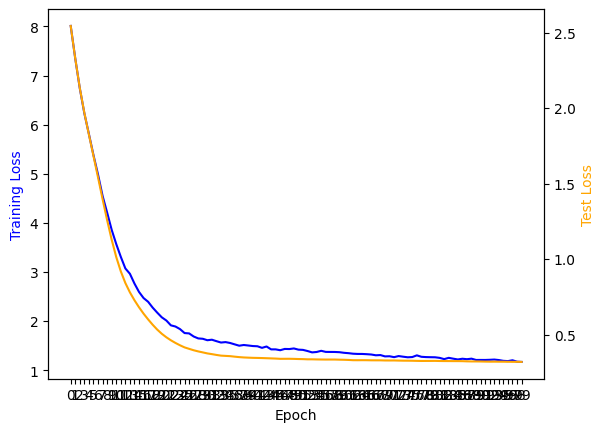

100%|██████████| 100/100 [00:04<00:00, 22.91it/s]

 Best Test Loss: 0.31834903359413147
RMSE: 0.449125
MAE: 0.387065


In [23]:
# Create single model
network = VariableANN(4, [4, 4, 4], 0.2)
opt = optim.Adam(network.parameters(), lr=0.001, weight_decay=0.0001)

trained_net = model.train_model("Model1", network, opt, loss_fn, epochs, plot_output=True)
test_rmse, _, test_predictions = model.validate_model(trained_net, "test")

[I 2024-08-29 10:23:29,087] A new study created in memory with name: no-name-76fd4c56-1ae5-498c-ae1d-772a7d87e339


Making temp model folder
Using existing directory at temp


100%|██████████| 100/100 [00:04<00:00, 24.87it/s]
[I 2024-08-29 10:23:33,124] Trial 0 finished with value: 0.421548 and parameters: {'dropout': 0.2, 'neurons0': 192, 'neurons1': 16, 'neurons2': 80, 'neurons3': 48, 'lr': 2.3407464805767515e-05, 'weight_decay': 2.3578730726467393e-05}. Best is trial 0 with value: 0.421548.


 Best Test Loss: 0.2787172496318817
RMSE: 0.421548
MAE: 0.360348
Making temp model folder
Using existing directory at temp


100%|██████████| 100/100 [00:03<00:00, 25.27it/s]
[I 2024-08-29 10:23:37,096] Trial 1 finished with value: 0.248894 and parameters: {'dropout': 0.15000000000000002, 'neurons0': 112, 'neurons1': 144, 'neurons2': 112, 'neurons3': 176, 'lr': 6.573686655138327e-05, 'weight_decay': 0.0005704727088203682}. Best is trial 1 with value: 0.248894.


 Best Test Loss: 0.09759647399187088
RMSE: 0.248894
MAE: 0.189734
Making temp model folder
Using existing directory at temp


100%|██████████| 100/100 [00:03<00:00, 26.17it/s]
[I 2024-08-29 10:23:40,932] Trial 2 finished with value: 0.239223 and parameters: {'dropout': 0.0, 'neurons0': 176, 'neurons1': 112, 'neurons2': 144, 'neurons3': 48, 'lr': 6.200203677164716e-05, 'weight_decay': 0.00039947456945609163}. Best is trial 2 with value: 0.239223.


 Best Test Loss: 0.09045276045799255
RMSE: 0.239223
MAE: 0.188178
Making temp model folder
Using existing directory at temp


100%|██████████| 100/100 [00:03<00:00, 25.03it/s]
[I 2024-08-29 10:23:44,941] Trial 3 finished with value: 0.504777 and parameters: {'dropout': 0.5, 'neurons0': 96, 'neurons1': 192, 'neurons2': 240, 'neurons3': 240, 'lr': 2.1886526657465428e-05, 'weight_decay': 1.197042490409919e-05}. Best is trial 2 with value: 0.239223.


 Best Test Loss: 0.3858867287635803
RMSE: 0.504777
MAE: 0.409286
Making temp model folder
Using existing directory at temp


100%|██████████| 100/100 [00:03<00:00, 25.81it/s]
[I 2024-08-29 10:23:48,830] Trial 4 finished with value: 0.072901 and parameters: {'dropout': 0.05, 'neurons0': 240, 'neurons1': 32, 'neurons2': 112, 'neurons3': 256, 'lr': 0.0013572540301313666, 'weight_decay': 0.00024196593469527324}. Best is trial 4 with value: 0.072901.


 Best Test Loss: 0.007390904240310192
RMSE: 0.072901
MAE: 0.054267
Making temp model folder
Using existing directory at temp


100%|██████████| 100/100 [00:03<00:00, 25.91it/s]
[I 2024-08-29 10:23:52,705] Trial 5 finished with value: 0.451734 and parameters: {'dropout': 0.15000000000000002, 'neurons0': 176, 'neurons1': 224, 'neurons2': 16, 'neurons3': 208, 'lr': 0.0902494067192741, 'weight_decay': 0.0003135676915341995}. Best is trial 4 with value: 0.072901.


 Best Test Loss: 0.3211265802383423
RMSE: 0.451734
MAE: 0.391437
Making temp model folder
Using existing directory at temp


100%|██████████| 100/100 [00:03<00:00, 26.18it/s]
[I 2024-08-29 10:23:56,540] Trial 6 finished with value: 0.135357 and parameters: {'dropout': 0.15000000000000002, 'neurons0': 208, 'neurons1': 32, 'neurons2': 128, 'neurons3': 240, 'lr': 0.0001494364677378836, 'weight_decay': 3.763142612534587e-05}. Best is trial 4 with value: 0.072901.


 Best Test Loss: 0.02876146137714386
RMSE: 0.135357
MAE: 0.098423
Making temp model folder
Using existing directory at temp


100%|██████████| 100/100 [00:03<00:00, 25.12it/s]
[I 2024-08-29 10:24:00,535] Trial 7 finished with value: 0.083982 and parameters: {'dropout': 0.05, 'neurons0': 16, 'neurons1': 176, 'neurons2': 64, 'neurons3': 80, 'lr': 0.0009253214657642581, 'weight_decay': 1.2785717080546074e-05}. Best is trial 4 with value: 0.072901.


 Best Test Loss: 0.01071864552795887
RMSE: 0.083982
MAE: 0.065513
Making temp model folder
Using existing directory at temp


100%|██████████| 100/100 [00:03<00:00, 25.13it/s]
[I 2024-08-29 10:24:04,529] Trial 8 finished with value: 0.159299 and parameters: {'dropout': 0.30000000000000004, 'neurons0': 48, 'neurons1': 160, 'neurons2': 192, 'neurons3': 32, 'lr': 0.00045313118440918, 'weight_decay': 0.0002447937444286876}. Best is trial 4 with value: 0.072901.


 Best Test Loss: 0.039849698543548584
RMSE: 0.159299
MAE: 0.128169
Making temp model folder
Using existing directory at temp


100%|██████████| 100/100 [00:04<00:00, 24.79it/s]
[I 2024-08-29 10:24:08,577] Trial 9 finished with value: 0.42565 and parameters: {'dropout': 0.2, 'neurons0': 16, 'neurons1': 144, 'neurons2': 176, 'neurons3': 144, 'lr': 0.06003147633638411, 'weight_decay': 0.00014897386352200276}. Best is trial 4 with value: 0.072901.


 Best Test Loss: 0.2837679386138916
RMSE: 0.42565
MAE: 0.365459
Making temp model folder
Using existing directory at temp


100%|██████████| 100/100 [00:03<00:00, 25.25it/s]
[I 2024-08-29 10:24:12,573] Trial 10 finished with value: 0.149107 and parameters: {'dropout': 0.35000000000000003, 'neurons0': 256, 'neurons1': 80, 'neurons2': 256, 'neurons3': 112, 'lr': 0.004852851779481773, 'weight_decay': 7.327696145109403e-05}. Best is trial 4 with value: 0.072901.


 Best Test Loss: 0.03190835192799568
RMSE: 0.149107
MAE: 0.122386
Making temp model folder
Using existing directory at temp


100%|██████████| 100/100 [00:03<00:00, 25.31it/s]
[I 2024-08-29 10:24:16,558] Trial 11 finished with value: 0.109358 and parameters: {'dropout': 0.0, 'neurons0': 64, 'neurons1': 256, 'neurons2': 48, 'neurons3': 96, 'lr': 0.0029114863197187714, 'weight_decay': 0.000927518876196669}. Best is trial 4 with value: 0.072901.


 Best Test Loss: 0.018306948244571686
RMSE: 0.109358
MAE: 0.07878
Making temp model folder
Using existing directory at temp


100%|██████████| 100/100 [00:03<00:00, 25.77it/s]
[I 2024-08-29 10:24:20,473] Trial 12 finished with value: 0.047326 and parameters: {'dropout': 0.05, 'neurons0': 240, 'neurons1': 80, 'neurons2': 80, 'neurons3': 96, 'lr': 0.0016690219230360306, 'weight_decay': 8.808234772855056e-05}. Best is trial 12 with value: 0.047326.


 Best Test Loss: 0.003400420071557164
RMSE: 0.047326
MAE: 0.03618
Making temp model folder
Using existing directory at temp


100%|██████████| 100/100 [00:03<00:00, 25.47it/s]
[I 2024-08-29 10:24:24,433] Trial 13 finished with value: 0.08192 and parameters: {'dropout': 0.05, 'neurons0': 256, 'neurons1': 64, 'neurons2': 96, 'neurons3': 160, 'lr': 0.012280238476692185, 'weight_decay': 9.031660557043444e-05}. Best is trial 12 with value: 0.047326.


 Best Test Loss: 0.0047424230724573135
RMSE: 0.08192
MAE: 0.066833
Making temp model folder
Using existing directory at temp


100%|██████████| 100/100 [00:03<00:00, 26.25it/s]
[I 2024-08-29 10:24:28,275] Trial 14 finished with value: 0.095323 and parameters: {'dropout': 0.1, 'neurons0': 240, 'neurons1': 64, 'neurons2': 16, 'neurons3': 192, 'lr': 0.0004411438203421464, 'weight_decay': 0.00015502807726359776}. Best is trial 12 with value: 0.047326.


 Best Test Loss: 0.014221004210412502
RMSE: 0.095323
MAE: 0.070987
Making temp model folder
Using existing directory at temp


100%|██████████| 100/100 [00:04<00:00, 24.67it/s]
[I 2024-08-29 10:24:32,363] Trial 15 finished with value: 0.093463 and parameters: {'dropout': 0.4, 'neurons0': 144, 'neurons1': 96, 'neurons2': 160, 'neurons3': 128, 'lr': 0.0027987712349286987, 'weight_decay': 4.338916893941725e-05}. Best is trial 12 with value: 0.047326.


 Best Test Loss: 0.01167311891913414
RMSE: 0.093463
MAE: 0.07404
Making temp model folder
Using existing directory at temp


100%|██████████| 100/100 [00:03<00:00, 25.65it/s]
[I 2024-08-29 10:24:36,295] Trial 16 finished with value: 0.067496 and parameters: {'dropout': 0.05, 'neurons0': 224, 'neurons1': 48, 'neurons2': 48, 'neurons3': 80, 'lr': 0.015179552139523395, 'weight_decay': 0.0001584552270614731}. Best is trial 12 with value: 0.047326.


 Best Test Loss: 0.005145263858139515
RMSE: 0.067496
MAE: 0.050251
Making temp model folder
Using existing directory at temp


100%|██████████| 100/100 [00:03<00:00, 25.58it/s]
[I 2024-08-29 10:24:40,237] Trial 17 finished with value: 0.088257 and parameters: {'dropout': 0.1, 'neurons0': 208, 'neurons1': 112, 'neurons2': 48, 'neurons3': 80, 'lr': 0.017769388271320966, 'weight_decay': 5.5361196314057384e-05}. Best is trial 12 with value: 0.047326.


 Best Test Loss: 0.011035498231649399
RMSE: 0.088257
MAE: 0.068797
Making temp model folder
Using existing directory at temp


100%|██████████| 100/100 [00:03<00:00, 25.39it/s]
[I 2024-08-29 10:24:44,210] Trial 18 finished with value: 0.141097 and parameters: {'dropout': 0.25, 'neurons0': 144, 'neurons1': 48, 'neurons2': 48, 'neurons3': 16, 'lr': 0.017501583911323126, 'weight_decay': 0.0001352501384480692}. Best is trial 12 with value: 0.047326.


 Best Test Loss: 0.031186824664473534
RMSE: 0.141097
MAE: 0.113216
Making temp model folder
Using existing directory at temp


100%|██████████| 100/100 [00:03<00:00, 25.90it/s]
[I 2024-08-29 10:24:48,104] Trial 19 finished with value: 0.040549 and parameters: {'dropout': 0.0, 'neurons0': 224, 'neurons1': 112, 'neurons2': 80, 'neurons3': 64, 'lr': 0.00717673527173512, 'weight_decay': 2.4204161752957207e-05}. Best is trial 19 with value: 0.040549.


 Best Test Loss: 0.0009550366667099297
RMSE: 0.040549
MAE: 0.029562
Study statistics: 
  Number of finished trials:  20
  Number of pruned trials:  0
  Number of complete trials:  20
Best trial:
  Value:  0.040549
  Params: 
    dropout: 0.0
    neurons0: 224
    neurons1: 112
    neurons2: 80
    neurons3: 64
    lr: 0.00717673527173512
    weight_decay: 2.4204161752957207e-05
Using existing directory at Model1


  0%|          | 3/1000 [00:00<00:35, 27.87it/s]

Best State Updated. Epoch: 0
Best State Updated. Epoch: 1
Best State Updated. Epoch: 2
Best State Updated. Epoch: 3
Best State Updated. Epoch: 4


  1%|          | 6/1000 [00:00<00:35, 27.63it/s]

Best State Updated. Epoch: 5


  1%|          | 9/1000 [00:00<00:35, 27.64it/s]

Best State Updated. Epoch: 6
Best State Updated. Epoch: 7
Best State Updated. Epoch: 8
Best State Updated. Epoch: 9


  1%|          | 12/1000 [00:00<00:35, 27.51it/s]

Best State Updated. Epoch: 11


  2%|▏         | 15/1000 [00:00<00:35, 27.59it/s]

Best State Updated. Epoch: 12
Best State Updated. Epoch: 13
Best State Updated. Epoch: 14
Best State Updated. Epoch: 15


  2%|▏         | 21/1000 [00:00<00:44, 22.19it/s]

Best State Updated. Epoch: 16
Best State Updated. Epoch: 17
Best State Updated. Epoch: 18
Best State Updated. Epoch: 19


  3%|▎         | 27/1000 [00:01<00:39, 24.90it/s]

Best State Updated. Epoch: 23
Best State Updated. Epoch: 24
Best State Updated. Epoch: 26


  4%|▎         | 36/1000 [00:01<00:35, 27.04it/s]

Best State Updated. Epoch: 30
Best State Updated. Epoch: 31


  4%|▍         | 42/1000 [00:01<00:34, 27.65it/s]

Best State Updated. Epoch: 36
Best State Updated. Epoch: 37
Best State Updated. Epoch: 39


  5%|▌         | 54/1000 [00:02<00:34, 27.71it/s]

Best State Updated. Epoch: 48
Best State Updated. Epoch: 49
Best State Updated. Epoch: 51


  7%|▋         | 69/1000 [00:02<00:34, 27.29it/s]

Best State Updated. Epoch: 64
Best State Updated. Epoch: 66
Best State Updated. Epoch: 67


  8%|▊         | 75/1000 [00:02<00:41, 22.10it/s]

Best State Updated. Epoch: 71


  8%|▊         | 84/1000 [00:03<00:37, 24.49it/s]

Best State Updated. Epoch: 79
Best State Updated. Epoch: 80
Best State Updated. Epoch: 81
Best State Updated. Epoch: 82


 10%|█         | 102/1000 [00:03<00:33, 27.05it/s]

Best State Updated. Epoch: 96


 14%|█▍        | 138/1000 [00:05<00:31, 27.08it/s]

Best State Updated. Epoch: 134
Best State Updated. Epoch: 136
Best State Updated. Epoch: 137


 25%|██▍       | 249/1000 [00:09<00:27, 26.85it/s]

Best State Updated. Epoch: 243
Best State Updated. Epoch: 248


 32%|███▏      | 324/1000 [00:12<00:24, 27.76it/s]

Best State Updated. Epoch: 320


 42%|████▏     | 417/1000 [00:15<00:21, 27.09it/s]

Best State Updated. Epoch: 412
Best State Updated. Epoch: 413


 51%|█████▏    | 513/1000 [00:19<00:18, 26.18it/s]

Best State Updated. Epoch: 509


 53%|█████▎    | 528/1000 [00:20<00:17, 26.59it/s]

Best State Updated. Epoch: 523


 56%|█████▌    | 555/1000 [00:21<00:18, 24.65it/s]

Best State Updated. Epoch: 549


 58%|█████▊    | 582/1000 [00:22<00:15, 27.00it/s]

Best State Updated. Epoch: 578


 62%|██████▏   | 615/1000 [00:23<00:15, 25.52it/s]

Best State Updated. Epoch: 610
Best State Updated. Epoch: 611
Best State Updated. Epoch: 612
Best State Updated. Epoch: 613
Best State Updated. Epoch: 614


 91%|█████████ | 912/1000 [00:35<00:03, 26.69it/s]

Best State Updated. Epoch: 906
Best State Updated. Epoch: 907


100%|█████████▉| 999/1000 [00:38<00:00, 28.46it/s]

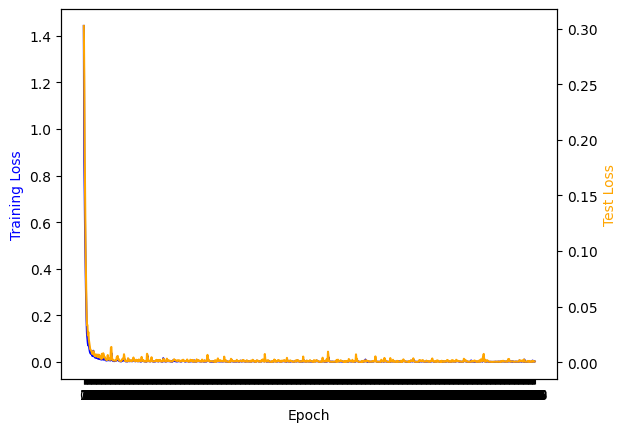

100%|██████████| 1000/1000 [00:41<00:00, 24.20it/s]

 Best Test Loss: 0.00029806705424562097


In [24]:
# Optimize model

network_dict = {
    "network": VariableANN,
    "kwargs": {"input_size": 4},
    "optimize_kwargs": {
        "dropout": {"name": "dropout", "low": 0.0, "high": 0.5, "step": 0.05},
        "neurons": {"name": "neurons", "low": 16, "high": 256, "step": 16, "multi": np.random.randint(3, 6)},
    },
}


optimizer_dict = {
    "optimizer": optim.Adam,
    "kwargs": {},
    "optimize_kwargs": {
        "lr": {"name": "lr", "low": 1e-5, "high": 1e-1, "log": True},
        "weight_decay": {"name": "weight_decay", "low": 1e-5, "high": 1e-3, "log": True},
    },
}

best_network, best_optimizer = model.optimize_network(
    trial_count, "minimize", network_dict, optimizer_dict, loss_fn, epochs
)

trained_net = model.train_model("Model1", best_network, best_optimizer, loss_fn, 1000, plot_output=True)

In [25]:
test_rmse, _, test_predictions = model.validate_model(trained_net, "test")

RMSE: 0.021364
MAE: 0.016799


## Optimization

In [1]:
def run_fn(radius, target_phi):
    freq = freq0
    feature_array = np.array((radius, radius, 0, freq))
    feature_array = feature_array.reshape((1, -1))
    prediction = model.make_prediction(trained_net, True, feature_array, 2)
    comp_num = prediction[0] + prediction[1] * 1j
    transmission = np.abs(comp_num)
    theta = np.angle(comp_num)

    return transmission * np.cos(target_phi - theta)

Determine desired metalens values

In [ ]:
R = 50 * lda0  # radius of the designed metalens

# define a grid of cells
r = np.arange(0, R, P)
print(f"The number of unit cells is {len(r)**2}.")
X, Y = np.meshgrid(r, r)

NA = 0.6  # numerical aperture of the designed metalens

f = R / NA * np.sqrt(1 - NA**2)  # focal length
print(f"The diameter of the metalens is {2*R/1e3:.3f} mm. The focal length is {f/1e3:.3f} mm.")

# desired phase profile
phi_map = (2 * np.pi * (f - np.sqrt(X**2 + Y**2 + f**2)) / lda0) % (-2 * np.pi) + np.pi

# plot the desired phase profile
plt.pcolormesh(X, Y, phi_map, cmap="binary")
plt.colorbar()
plt.show()

Break the phi map down into X points and optimise structures for those points

In [34]:
optimization_points = 50
phi_range = np.linspace(phi_map.min(), phi_map.max(), optimization_points)

In [35]:
phi_dict = {}
for target_phi in phi_range:
    # Design space defined new each time 
    method = tdd.MethodBayOpt(
        initial_iter=300,
        n_iter=5,
        acq_func='ucb',
        kappa=3,
        xi=0.9,
        seed=1,
    )

    # Easiest way to get target_phi into the optimization
    # predict_parameters = parameters + [tdd.ParameterFloat(name="target_phi", span=(target_phi, target_phi))]
    phi = tdd.ParameterFloat(name="target_phi", span=(target_phi, target_phi))
    rad = tdd.ParameterFloat(name="radius", span=(0.75, 1.8))
    predict_parameters = [rad, phi]

    output_dir = "/home/matt/Documents/Flexcompute/metalens2/data"
    design_space = tdd.DesignSpace(
        method=method,
        parameters=predict_parameters,
        task_name="metalens_predict_1",
        folder_name="MetalensV2",
        path_dir=output_dir,
    )
    
    predict_results = design_space.run(run_fn, verbose=True)
    phi_dict[target_phi] = predict_results.optimizer.max['params'].values()

10:50:15 BST Best Fit from Initial Solutions: 0.861                             
             

             Latest Best Fit on Iter 0: 0.861                                   
             

Data point [ 0.75       -3.14141227] is not unique. 1 duplicates registered. Continuing ...
Data point [ 0.75       -3.14141227] is not unique. 2 duplicates registered. Continuing ...
Data point [ 0.75       -3.14141227] is not unique. 3 duplicates registered. Continuing ...
Data point [ 0.75       -3.14141227] is not unique. 4 duplicates registered. Continuing ...


10:50:17 BST Best Result: 0.8607455100407736                                    
             Best Parameters: radius: 0.75 target_phi: -3.1414122660566726      
             

             Best Fit from Initial Solutions: 0.87                              
             

10:50:18 BST Latest Best Fit on Iter 0: 0.87                                    
             

Data point [ 0.75       -3.01318768] is not unique. 1 duplicates registered. Continuing ...
Data point [ 0.75       -3.01318768] is not unique. 2 duplicates registered. Continuing ...
Data point [ 0.75       -3.01318768] is not unique. 3 duplicates registered. Continuing ...
Data point [ 0.75       -3.01318768] is not unique. 4 duplicates registered. Continuing ...


10:50:20 BST Best Result: 0.8703313238302106                                    
             Best Parameters: radius: 0.75 target_phi: -3.0131876758598057      
             

             Best Fit from Initial Solutions: 0.866                             
             

10:50:21 BST Latest Best Fit on Iter 1: 0.866                                   
             

Data point [ 0.75       -2.88496309] is not unique. 1 duplicates registered. Continuing ...
Data point [ 0.75       -2.88496309] is not unique. 2 duplicates registered. Continuing ...


10:50:23 BST Best Result: 0.865627140773922                                     
             Best Parameters: radius: 0.75 target_phi: -2.8849630856629394      
             

             Best Fit from Initial Solutions: 0.86                              
             

10:50:25 BST Latest Best Fit on Iter 3: 0.861                                   
             

             Best Result: 0.8605290370563498                                    
             Best Parameters: radius: 0.8366486322936817 target_phi:            
             -2.7567384954660725                                                
             

10:50:26 BST Best Fit from Initial Solutions: 0.86                              
             

10:50:30 BST Best Result: 0.8595400950303923                                    
             Best Parameters: radius: 0.9005942011037571 target_phi:            
             -2.628513905269206                                                 
             

10:50:31 BST Best Fit from Initial Solutions: 0.864                             
             

10:50:34 BST Best Result: 0.8635065360107571                                    
             Best Parameters: radius: 0.9005942011037571 target_phi:            
             -2.5002893150723393                                                
             

             Best Fit from Initial Solutions: 0.863                             
             

             Latest Best Fit on Iter 0: 0.863                                   
             

10:50:35 BST Latest Best Fit on Iter 1: 0.863                                   
             

10:50:37 BST Best Result: 0.8632262186907096                                    
             Best Parameters: radius: 0.956648778864789 target_phi:             
             -2.3720647248754725                                                
             

10:50:38 BST Best Fit from Initial Solutions: 0.864                             
             

             Latest Best Fit on Iter 0: 0.864                                   
             

10:50:42 BST Best Result: 0.8639666606847201                                    
             Best Parameters: radius: 0.959508963768946 target_phi:             
             -2.243840134678606                                                 
             

             Best Fit from Initial Solutions: 0.85                              
             

             Latest Best Fit on Iter 0: 0.85                                    
             

10:50:45 BST Latest Best Fit on Iter 4: 0.851                                   
             

             Best Result: 0.8505692842720446                                    
             Best Parameters: radius: 0.9609199673173505 target_phi:            
             -2.1156155444817397                                                
             

             Best Fit from Initial Solutions: 0.835                             
             

10:50:46 BST Latest Best Fit on Iter 0: 0.836                                   
             

10:50:48 BST Latest Best Fit on Iter 4: 0.836                                   
             

             Best Result: 0.8357433962483565                                    
             Best Parameters: radius: 1.0054867065996707 target_phi:            
             -1.987390954284873                                                 
             

             Best Fit from Initial Solutions: 0.82                              
             

10:50:49 BST Latest Best Fit on Iter 0: 0.82                                    
             

10:50:51 BST Best Result: 0.8202772717952606                                    
             Best Parameters: radius: 1.0080320148899062 target_phi:            
             -1.8591663640880063                                                
             

10:50:52 BST Best Fit from Initial Solutions: 0.809                             
             

10:50:56 BST Best Result: 0.8091074132445605                                    
             Best Parameters: radius: 1.0444661916676254 target_phi:            
             -1.7309417738911397                                                
             

             Best Fit from Initial Solutions: 0.801                             
             

             Latest Best Fit on Iter 0: 0.803                                   
             

10:51:00 BST Best Result: 0.8033764779058348                                    
             Best Parameters: radius: 1.0577003642111684 target_phi:            
             -1.6027171836942729                                                
             

             Best Fit from Initial Solutions: 0.789                             
             

10:51:01 BST Latest Best Fit on Iter 0: 0.789                                   
             

10:51:04 BST Best Result: 0.7892791537646473                                    
             Best Parameters: radius: 1.0694327992735284 target_phi:            
             -1.4744925934974062                                                
             

             Best Fit from Initial Solutions: 0.787                             
             

10:51:07 BST Best Result: 0.7865000587871601                                    
             Best Parameters: radius: 1.092977146860701 target_phi:             
             -1.3462680033005396                                                
             

             Best Fit from Initial Solutions: 0.784                             
             

10:51:09 BST Latest Best Fit on Iter 0: 0.785                                   
             

10:51:10 BST Latest Best Fit on Iter 1: 0.785                                   
             

10:51:11 BST Latest Best Fit on Iter 2: 0.785                                   
             

             Latest Best Fit on Iter 3: 0.786                                   
             

10:51:13 BST Latest Best Fit on Iter 4: 0.786                                   
             

             Best Result: 0.7855201993392268                                    
             Best Parameters: radius: 1.0969272855112624 target_phi:            
             -1.218043413103673                                                 
             

             Best Fit from Initial Solutions: 0.777                             
             

10:51:14 BST Latest Best Fit on Iter 0: 0.777                                   
             

10:51:15 BST Latest Best Fit on Iter 3: 0.778                                   
             

10:51:16 BST Best Result: 0.7775002623440584                                    
             Best Parameters: radius: 1.1022283714235883 target_phi:            
             -1.0898188229068064                                                
             

             Best Fit from Initial Solutions: 0.778                             
             

10:51:18 BST Latest Best Fit on Iter 2: 0.778                                   
             

10:51:19 BST Latest Best Fit on Iter 3: 0.778                                   
             

             Latest Best Fit on Iter 4: 0.778                                   
             

             Best Result: 0.7782646803783574                                    
             Best Parameters: radius: 1.1217178424834566 target_phi:            
             -0.9615942327099396                                                
             

10:51:20 BST Best Fit from Initial Solutions: 0.777                             
             

             Latest Best Fit on Iter 0: 0.782                                   
             

10:51:23 BST Best Result: 0.7816521765364113                                    
             Best Parameters: radius: 1.129600075358298 target_phi:             
             -0.8333696425130732                                                
             

             Best Fit from Initial Solutions: 0.775                             
             

10:51:24 BST Latest Best Fit on Iter 0: 0.78                                    
             

10:51:27 BST Best Result: 0.7803578242268289                                    
             Best Parameters: radius: 1.1340174661327094 target_phi:            
             -0.7051450523162064                                                
             

             Best Fit from Initial Solutions: 0.774                             
             

10:51:28 BST Latest Best Fit on Iter 0: 0.774                                   
             

10:51:29 BST Latest Best Fit on Iter 1: 0.774                                   
             

10:51:31 BST Latest Best Fit on Iter 2: 0.774                                   
             

             Latest Best Fit on Iter 3: 0.774                                   
             

10:51:33 BST Best Result: 0.7736938268526533                                    
             Best Parameters: radius: 1.1409530072880423 target_phi:            
             -0.57692046211934                                                  
             

             Best Fit from Initial Solutions: 0.766                             
             

             Latest Best Fit on Iter 0: 0.768                                   
             

10:51:35 BST Best Result: 0.7677129866372941                                    
             Best Parameters: radius: 1.1443090824510234 target_phi:            
             -0.4486958719224732                                                
             

10:51:36 BST Best Fit from Initial Solutions: 0.749                             
             

10:51:38 BST Best Result: 0.7492414979497265                                    
             Best Parameters: radius: 1.1454093304830633 target_phi:            
             -0.3204712817256068                                                
             

             Best Fit from Initial Solutions: 0.732                             
             

10:51:43 BST Best Result: 0.7320194975388907                                    
             Best Parameters: radius: 1.1646193935697327 target_phi:            
             -0.19224669152873997                                               
             

             Best Fit from Initial Solutions: 0.726                             
             

10:51:46 BST Best Result: 0.7261635827108355                                    
             Best Parameters: radius: 1.1646193935697327 target_phi:            
             -0.06402210133187314                                               
             

10:51:47 BST Best Fit from Initial Solutions: 0.708                             
             

10:51:50 BST Best Result: 0.708384765624418                                     
             Best Parameters: radius: 1.1646193935697327 target_phi:            
             0.06420248886499325                                                
             

             Best Fit from Initial Solutions: 0.69                              
             

10:51:53 BST Best Result: 0.6903121536449612                                    
             Best Parameters: radius: 1.1785436428993452 target_phi:            
             0.19242707906186007                                                
             

             Best Fit from Initial Solutions: 0.677                             
             

             Latest Best Fit on Iter 0: 0.677                                   
             

10:51:54 BST Latest Best Fit on Iter 1: 0.677                                   
             

10:51:56 BST Best Result: 0.677064131810036                                     
             Best Parameters: radius: 1.1798043849539868 target_phi:            
             0.32065166925872646                                                
             

             Best Fit from Initial Solutions: 0.662                             
             

10:52:00 BST Best Result: 0.6624310185625887                                    
             Best Parameters: radius: 1.1977985279264658 target_phi:            
             0.4488762594555933                                                 
             

             Best Fit from Initial Solutions: 0.664                             
             

10:52:01 BST Latest Best Fit on Iter 0: 0.664                                   
             

             Latest Best Fit on Iter 1: 0.664                                   
             

10:52:02 BST Latest Best Fit on Iter 2: 0.664                                   
             

             Latest Best Fit on Iter 3: 0.664                                   
             

10:52:04 BST Latest Best Fit on Iter 4: 0.664                                   
             

             Best Result: 0.6642676092146235                                    
             Best Parameters: radius: 1.1989794386050552 target_phi:            
             0.5771008496524597                                                 
             

             Best Fit from Initial Solutions: 0.655                             
             

10:52:07 BST Best Result: 0.655232762263565                                     
             Best Parameters: radius: 1.1994957493648597 target_phi:            
             0.7053254398493265                                                 
             

10:52:08 BST Best Fit from Initial Solutions: 0.636                             
             

10:52:11 BST Best Result: 0.6355085233366149                                    
             Best Parameters: radius: 1.1994957493648597 target_phi:            
             0.8335500300461929                                                 
             

             Best Fit from Initial Solutions: 0.639                             
             

10:52:14 BST Best Result: 0.6388908398688392                                    
             Best Parameters: radius: 1.2328742791076475 target_phi:            
             0.9617746202430597                                                 
             

             Best Fit from Initial Solutions: 0.639                             
             

10:52:15 BST Latest Best Fit on Iter 0: 0.639                                   
             

10:52:19 BST Best Result: 0.6394093410831112                                    
             Best Parameters: radius: 1.2365554797507248 target_phi:            
             1.0899992104399265                                                 
             

             Best Fit from Initial Solutions: 0.665                             
             

10:52:20 BST Latest Best Fit on Iter 1: 0.666                                   
             

10:52:21 BST Latest Best Fit on Iter 2: 0.666                                   
             

10:52:22 BST Latest Best Fit on Iter 3: 0.666                                   
             

             Latest Best Fit on Iter 4: 0.666                                   
             

             Best Result: 0.6656368393465986                                    
             Best Parameters: radius: 1.269799816609281 target_phi:             
             1.2182238006367934                                                 
             

             Best Fit from Initial Solutions: 0.7                               
             

10:52:25 BST Latest Best Fit on Iter 2: 0.7                                     
             

10:52:26 BST Best Result: 0.6997271985015957                                    
             Best Parameters: radius: 1.322181413157622 target_phi:             
             1.3464483908336593                                                 
             

10:52:27 BST Best Fit from Initial Solutions: 0.747                             
             

             Latest Best Fit on Iter 0: 0.747                                   
             

10:52:29 BST Latest Best Fit on Iter 3: 0.748                                   
             

10:52:30 BST Best Result: 0.7475302290313357                                    
             Best Parameters: radius: 1.3259934748907634 target_phi:            
             1.4746729810305261                                                 
             

             Best Fit from Initial Solutions: 0.787                             
             

10:52:33 BST Best Result: 0.7871170332208969                                    
             Best Parameters: radius: 1.3377028311568497 target_phi:            
             1.602897571227393                                                  
             

             Best Fit from Initial Solutions: 0.816                             
             

10:52:34 BST Latest Best Fit on Iter 0: 0.816                                   
             

10:52:37 BST Best Result: 0.8161114153925859                                    
             Best Parameters: radius: 1.3383079792641848 target_phi:            
             1.7311221614242598                                                 
             

             Best Fit from Initial Solutions: 0.832                             
             

10:52:40 BST Best Result: 0.8316500674385066                                    
             Best Parameters: radius: 1.3390817302184956 target_phi:            
             1.8593467516211257                                                 
             

             Best Fit from Initial Solutions: 0.838                             
             

10:52:42 BST Latest Best Fit on Iter 2: 0.838                                   
             

10:52:43 BST Best Result: 0.8382794455658592                                    
             Best Parameters: radius: 1.3663166247228913 target_phi:            
             1.9875713418179926                                                 
             

             Best Fit from Initial Solutions: 0.846                             
             

10:52:45 BST Latest Best Fit on Iter 2: 0.846                                   
             

10:52:46 BST Best Result: 0.8458850998762406                                    
             Best Parameters: radius: 1.3752803172578552 target_phi:            
             2.1157959320148594                                                 
             

             Best Fit from Initial Solutions: 0.844                             
             

10:52:50 BST Best Result: 0.8439523281378323                                    
             Best Parameters: radius: 1.384526007065972 target_phi:             
             2.244020522211726                                                  
             

             Best Fit from Initial Solutions: 0.838                             
             

10:52:51 BST Latest Best Fit on Iter 2: 0.838                                   
             

10:52:53 BST Best Result: 0.838392253819773                                     
             Best Parameters: radius: 1.4293068066793806 target_phi:            
             2.372245112408593                                                  
             

             Best Fit from Initial Solutions: 0.829                             
             

10:52:54 BST Latest Best Fit on Iter 0: 0.831                                   
             

10:52:55 BST Latest Best Fit on Iter 2: 0.831                                   
             

10:52:56 BST Latest Best Fit on Iter 3: 0.831                                   
             

10:52:57 BST Latest Best Fit on Iter 4: 0.831                                   
             

             Best Result: 0.8310157590185615                                    
             Best Parameters: radius: 1.4339607475250464 target_phi:            
             2.500469702605459                                                  
             

             Best Fit from Initial Solutions: 0.818                             
             

10:52:58 BST Latest Best Fit on Iter 0: 0.818                                   
             

10:53:00 BST Latest Best Fit on Iter 4: 0.818                                   
             

             Best Result: 0.81829840141115                                      
             Best Parameters: radius: 1.4786633119521555 target_phi:            
             2.628694292802326                                                  
             

             Best Fit from Initial Solutions: 0.805                             
             

10:53:04 BST Best Result: 0.8053644296268327                                    
             Best Parameters: radius: 1.4791201656141324 target_phi:            
             2.7569188829991926                                                 
             

             Best Fit from Initial Solutions: 0.804                             
             

10:53:08 BST Best Result: 0.8041613885414177                                    
             Best Parameters: radius: 1.562489251606391 target_phi:             
             2.8851434731960595                                                 
             

             Best Fit from Initial Solutions: 0.837                             
             

10:53:09 BST Latest Best Fit on Iter 0: 0.837                                   
             

Data point [0.75       3.01336806] is not unique. 1 duplicates registered. Continuing ...
Data point [0.75       3.01336806] is not unique. 2 duplicates registered. Continuing ...
Data point [0.75       3.01336806] is not unique. 3 duplicates registered. Continuing ...
Data point [0.75       3.01336806] is not unique. 4 duplicates registered. Continuing ...


10:53:11 BST Best Result: 0.836983923103911                                     
             Best Parameters: radius: 0.75 target_phi: 3.0133680633929263       
             

             Best Fit from Initial Solutions: 0.861                             
             

10:53:12 BST Latest Best Fit on Iter 0: 0.861                                   
             

Data point [0.75       3.14159265] is not unique. 1 duplicates registered. Continuing ...
Data point [0.75       3.14159265] is not unique. 2 duplicates registered. Continuing ...
Data point [0.75       3.14159265] is not unique. 3 duplicates registered. Continuing ...
Data point [0.75       3.14159265] is not unique. 4 duplicates registered. Continuing ...


10:53:15 BST Best Result: 0.8607220053672792                                    
             Best Parameters: radius: 0.75 target_phi: 3.141592653589793        
             

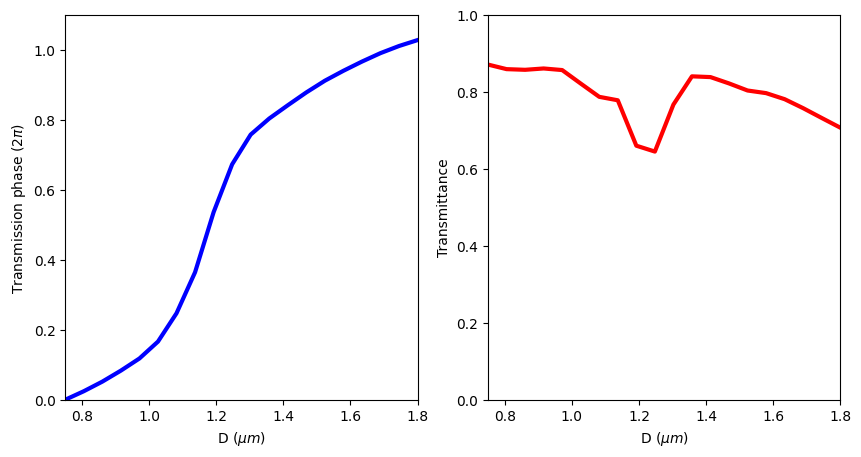

In [30]:
# Plot test for cylinders
rad_values = np.linspace(0.75, 1.8, 20)

complex_vals = []
for rad in rad_values:
    feature_array = np.array((rad, rad, 0, freq0))
    feature_array = feature_array.reshape((1, -1))
    prediction = model.make_prediction(trained_net, True, feature_array, 2)
    comp_num = prediction[0] + prediction[1] * 1j
    complex_vals.append(comp_num)

complex_arr = np.array(complex_vals)
theta = np.unwrap(np.angle(complex_arr))

# plot the transmission phase
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
theta = theta - theta[0]
ax1.plot(rad_values, theta / (2 * np.pi), linewidth=3, c="blue")
ax1.set_xlim(np.min(rad_values), np.max(rad_values))
ax1.set_ylim(0, 1.1)
ax1.set_xlabel("D ($\mu m$)")
ax1.set_ylabel("Transmission phase ($2\pi$)")

# plot the transmittance
ax2.plot(rad_values, np.abs(complex_arr), linewidth=3, c="red")
ax2.set_xlim(np.min(rad_values), np.max(rad_values))
ax2.set_ylim(0, 1)
ax2.set_xlabel("D ($\mu m$)")
ax2.set_ylabel("Transmittance")
plt.show()

In [74]:
# ideal_structures = np.zeros(shape=(phi_map.shape[0], phi_map.shape[1], 4))
# for i in range(len(phi_map)):
#     for j in range(len(phi_map)):
#         target_phi = phi_map[i][j]
        
#         # Design space defined new each time 
#         method = tdd.MethodBayOpt(
#             initial_iter=200,
#             n_iter=10,
#             acq_func='ucb',
#             kappa=3,
#             xi=0.9,
#             seed=1,
#         )

#         # Easiest way to get target_phi into the optimization
#         predict_parameters = parameters + [tdd.ParameterFloat(name="target_phi", span=(target_phi, target_phi))]

#         output_dir = "/home/matt/Documents/Flexcompute/metalens2/data"
#         design_space = tdd.DesignSpace(
#             method=method,
#             parameters=predict_parameters,
#             task_name="metalens_predict_1",
#             folder_name="MetalensV2",
#             path_dir=output_dir,
#         )
        
#         predict_results = design_space.run(run_fn, verbose=False)
#         ideal_structures[i][j] = np.array(list(predict_results.optimizer.max['params'].values()))

# # create pillar geometries at each cell to follow the desired phase profile
# ellipsis_structures = []
# for i, x in enumerate(r):
#     for j, y in enumerate(r):
#         if x**2 + y**2 <= R**2 and x >= 0 and y >= 0:
#             ideal_params = ideal_structures[i][j]
#             # BayOpt outputs params in alphabetical order
#             ellipsis = create_ellipsis(ideal_params[1], ideal_params[2], ideal_params[0], x, y)
#             ellipsis_structures.append(ellipsis)


In [36]:
import xarray
coords = {"phi": list(phi_dict.keys())}
dims = ["phi", "row"]
data = np.array([np.array(list(row)) for row in phi_dict.values()])
phi_array = xarray.DataArray(data=data, coords=coords, dims=dims)

# print(phi_array.sel(phi=3.11, method="nearest"))

os.chdir("/home/matt/Documents/Flexcompute/metalens_linear_source/data")
with open("phi_array.pkl", "wb") as out_file:
    pickle.dump(phi_array, out_file)

# with open("phi_array.pkl", "rb") as in_file:
#     phi_array = pickle.load(in_file)


Make output an xarray and then use .sel nearest to pick the appropriate structures
Wonder if just taking abs of x and y offsets would fix positioning issue?

Build the simulation from the ideal structures https://www.flexcompute.com/tidy3d/examples/notebooks/MidIRMetalens/

In [39]:
# create pillar geometries at each cell to follow the desired phase profile
ellipsis_structures = []
for i, x in enumerate(r):
    for j, y in enumerate(r):
        if x**2 + y**2 <= R**2 and x >= 0 and y >= 0:
            ideal_params = phi_array.sel(phi=phi_map[i][j], method="nearest").data
            # BayOpt outputs params in alphabetical order
            # ellipsis = create_ellipsis(ideal_params[1], ideal_params[2], ideal_params[0], x, y)
            ellipsis = create_ellipsis(ideal_params[0], ideal_params[0], 0, x, y)
            ellipsis_structures.append(ellipsis)


In [40]:
# simulation domain size
Lx = 2 * R + lda0
Ly = 2 * R + lda0
Lz = h + 1.3 * lda0

# grids of the projected field position
xs_far = np.linspace(-3 * lda0, 3 * lda0, 101)
ys_far = np.linspace(-3 * lda0, 3 * lda0, 101)

# define a field projection monitor
monitor_proj = td.FieldProjectionCartesianMonitor(
    center=[0, 0, h + 0.6 * lda0],
    size=[td.inf, td.inf, 0],
    freqs=[freq0],
    name="focal_plane_proj",
    proj_axis=2,
    proj_distance=f,
    x=xs_far,
    y=ys_far,
    custom_origin=(0, 0, 0),
    far_field_approx=False,
)

# define geometry
substrate_geo = td.Box.from_bounds(rmin=(-inf_eff, -inf_eff, -inf_eff), rmax=(inf_eff, inf_eff, 0))
substrate = td.Structure(geometry=substrate_geo, medium=si, name="substrate")

# add a plane wave source
plane_wave1 = td.PlaneWave(
    source_time=td.GaussianPulse(freq0=freq0, fwidth=freq0 / 10),
    size=(td.inf, td.inf, 0),
    center=(0, 0, -0.1 * lda0),
    direction="+",
)

run_time = 5e-12  # simulation run time
min_steps_per_wvl = 12

# define the simulation
metalens_sim = td.Simulation(
    center=(0, 0, Lz / 2 - lda0 / 2),
    size=(Lx, Ly, Lz),
    grid_spec=td.GridSpec.auto(min_steps_per_wvl=min_steps_per_wvl, wavelength=lda0),
    structures=ellipsis_structures + [substrate],
    sources=[plane_wave1],
    monitors=[monitor_proj],
    run_time=run_time,
    boundary_spec=td.BoundarySpec(x=td.Boundary.pml(), y=td.Boundary.pml(), z=td.Boundary.pml()),
    symmetry=(-1, 1, 0),
)

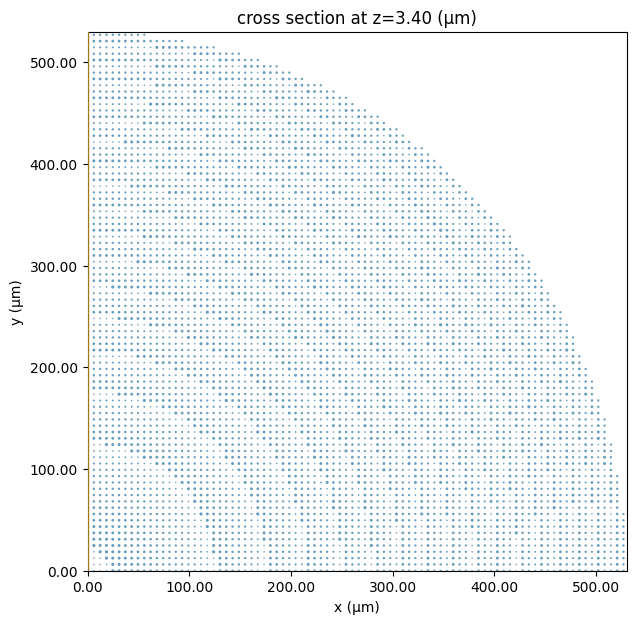

In [42]:
fig, ax = plt.subplots(figsize=(7, 7))
metalens_sim.plot(z=h / 2, ax=ax)
ax.set_xlim(0, R)
ax.set_ylim(0, R)
plt.show()

In [43]:
import tidy3d.web as web
# sim_data = web.run(metalens_sim, task_name="metalens_full_sim")
job = web.Job(simulation=metalens_sim, task_name="ir_metalens")
estimated_cost = web.estimate_cost(job.task_id)

11:05:44 BST Created task 'ir_metalens' with task_id                            
             'fdve-664338af-16f6-4fdd-b483-b7d1c6523583' and task_type 'FDTD'.

             View task using web UI at                                          
             ]8;id=913197;https://tidy3d.simulation.cloud/workbench?taskId=fdve-664338af-16f6-4fdd-b483-b7d1c6523583\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=787775;https://tidy3d.simulation.cloud/workbench?taskId=fdve-664338af-16f6-4fdd-b483-b7d1c6523583\taskId]8;;\]8;id=913197;https://tidy3d.simulation.cloud/workbench?taskId=fdve-664338af-16f6-4fdd-b483-b7d1c6523583\=]8;;\]8;id=499270;https://tidy3d.simulation.cloud/workbench?taskId=fdve-664338af-16f6-4fdd-b483-b7d1c6523583\fdve]8;;\]8;id=913197;https://tidy3d.simulation.cloud/workbench?taskId=fdve-664338af-16f6-4fdd-b483-b7d1c6523583\-664338af-16f]8;;\
             ]8;id=913197;https://tidy3d.simulation.cloud/workbench?taskId=fdve-664338af-16f6-4fdd-b483-b7d1c6523583\6-4fdd-b483-b7d1c6523583']8;;\.

Output()

11:06:12 BST Maximum FlexCredit cost: 2.750. Minimum cost depends on task       
             execution details. Use 'web.real_cost(task_id)' to get the billed  
             FlexCredit cost after a simulation run.

               0.105 FlexCredit of the total cost from post-processing.

In [44]:
sim_data = web.run(metalens_sim, task_name="metalens_full_sim")

11:06:17 BST Created task 'metalens_full_sim' with task_id                      
             'fdve-6aa43541-1e5e-407c-a4e9-3c1fcce1a847' and task_type 'FDTD'.

             View task using web UI at                                          
             ]8;id=858532;https://tidy3d.simulation.cloud/workbench?taskId=fdve-6aa43541-1e5e-407c-a4e9-3c1fcce1a847\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=261207;https://tidy3d.simulation.cloud/workbench?taskId=fdve-6aa43541-1e5e-407c-a4e9-3c1fcce1a847\taskId]8;;\]8;id=858532;https://tidy3d.simulation.cloud/workbench?taskId=fdve-6aa43541-1e5e-407c-a4e9-3c1fcce1a847\=]8;;\]8;id=578651;https://tidy3d.simulation.cloud/workbench?taskId=fdve-6aa43541-1e5e-407c-a4e9-3c1fcce1a847\fdve]8;;\]8;id=858532;https://tidy3d.simulation.cloud/workbench?taskId=fdve-6aa43541-1e5e-407c-a4e9-3c1fcce1a847\-6aa43541-1e5]8;;\
             ]8;id=858532;https://tidy3d.simulation.cloud/workbench?taskId=fdve-6aa43541-1e5e-407c-a4e9-3c1fcce1a847\e-407c-a4e9-3c1fcce1a847']8;;\.

Output()

11:06:27 BST status = queued

             To cancel the simulation, use 'web.abort(task_id)' or              
             'web.delete(task_id)' or abort/delete the task in the web UI.      
             Terminating the Python script will not stop the job running on the 
             cloud.

Output()

11:07:43 BST status = preprocess

11:08:18 BST Maximum FlexCredit cost: 2.750. Use 'web.real_cost(task_id)' to get
             the billed FlexCredit cost after a simulation run.

             starting up solver

             running solver

Output()

11:12:38 BST early shutoff detected at 56%, exiting.

             status = postprocess

Output()

11:12:42 BST status = success

             View simulation result at                                          
             ]8;id=388097;https://tidy3d.simulation.cloud/workbench?taskId=fdve-6aa43541-1e5e-407c-a4e9-3c1fcce1a847\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=649875;https://tidy3d.simulation.cloud/workbench?taskId=fdve-6aa43541-1e5e-407c-a4e9-3c1fcce1a847\taskId]8;;\]8;id=388097;https://tidy3d.simulation.cloud/workbench?taskId=fdve-6aa43541-1e5e-407c-a4e9-3c1fcce1a847\=]8;;\]8;id=312775;https://tidy3d.simulation.cloud/workbench?taskId=fdve-6aa43541-1e5e-407c-a4e9-3c1fcce1a847\fdve]8;;\]8;id=388097;https://tidy3d.simulation.cloud/workbench?taskId=fdve-6aa43541-1e5e-407c-a4e9-3c1fcce1a847\-6aa43541-1e5]8;;\
             ]8;id=388097;https://tidy3d.simulation.cloud/workbench?taskId=fdve-6aa43541-1e5e-407c-a4e9-3c1fcce1a847\e-407c-a4e9-3c1fcce1a847']8;;\.

Output()

11:12:45 BST loading simulation from simulation_data.hdf5

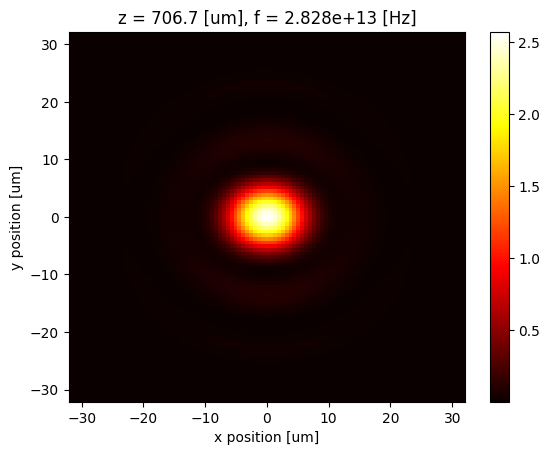

In [45]:
proj_fields = sim_data["focal_plane_proj"].fields_cartesian.sel(f=freq0)

# compute the intensity of the field
I = np.abs(proj_fields.Ex) ** 2 + np.abs(proj_fields.Ey) ** 2 + np.abs(proj_fields.Ez) ** 2

# plot field distribution
I.plot(x="x", y="y", cmap="hot")
plt.show()

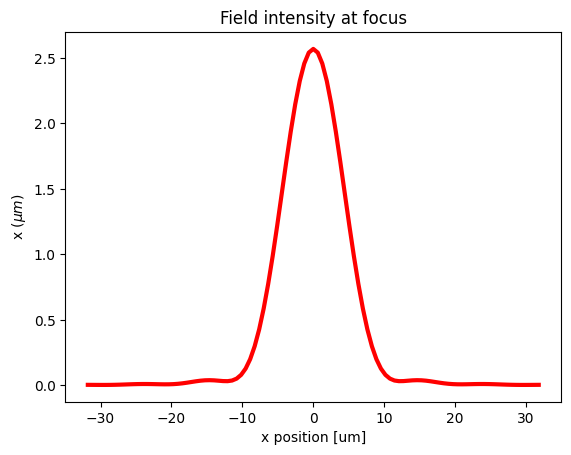

The FWHM is 10.176 um. Wavelength was 10.6 um.


In [46]:
I_x = I.sel(y=0, z=f, method="nearest")  # extract the field intensity in the x direction

# plot the intensity profile
fig, ax = plt.subplots()
I_x.plot(linewidth=3, c="red", ax=ax)
ax.set_ylabel("Intensity")
ax.set_ylabel("x ($\mu m$)")
ax.set_title("Field intensity at focus")
plt.show()

# function for determining the fwhm
def cal_fwhm(x, y):

    # filter the data
    y = y[x > 0]
    x = x[x > 0]
    x = x[y > 0.4 * np.max(y)]
    y = y[y > 0.4 * np.max(y)]

    # compute half width by interpolation
    hm_point = np.interp(np.max(y) / 2, y, x)

    # compute full width
    fwhm_value = 2 * hm_point

    return fwhm_value

# calculate fwhm
fwhm = cal_fwhm(I_x.x.values, I_x.values)
print(f"The FWHM is {fwhm:.3f} um. Wavelength was {lda0} um.")